# Demo for how to perform "the ultimate fit" when tracking capillaries. In the ultimate fit, several (below we fit two profiles) line-profiles are fitted in time simultaneously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../../sl2pm')

import track_vessel
from models import L_multi, L_multi_plasma, L_multi_wall
import misc

## Protocol A: The Ultimate Fit (both plasma and wall fluorescence)

In [2]:
kymo_wall = np.load('wall.npy')
kymo_plasma = np.load('plasma.npy')

nt, nx = kymo_wall.shape
x = np.arange(nx)

kymo_wall = kymo_wall.reshape((2, nt//2, nx)).mean(axis=1)
kymo_plasma = kymo_plasma.reshape((2, nt//2, nx)).mean(axis=1)

N_AVER = nt//2

## Enter PMT parameters (known from the calibration)

In [3]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Make an initial parameter guess

In [4]:
xc, s_xy, l, R_lum, R_wall, s_gcx, a1, Iw, Ip, b_plasma, b_tissue_wall, b_tissue_plasma = track_vessel.ols_wall_plasma(kymo_wall[0]/GAIN, 
                                    kymo_plasma[0]/GAIN, 
                                    sigma_blur=1.5)

p0_A = [s_xy, l, R_wall - R_lum, s_gcx, b_plasma, b_tissue_wall, b_tissue_plasma, 
        *(2*[Iw]), *(2*[Ip]), *(2*[R_wall]), *(2*[xc]), *(2*[a1])]

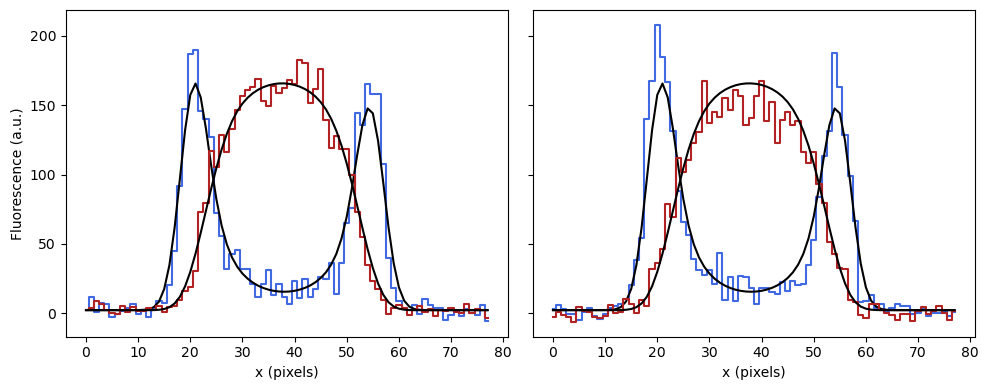

In [5]:
[[w1_A0, p1_A0], [w2_A0, p2_A0]] = L_multi(x, *p0_A)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0], where='mid', c='royalblue')
ax1.plot(x, w1_A0*GAIN, c='k')

ax1.step(x, kymo_plasma[0], where='mid', c='firebrick')
ax1.plot(x, p1_A0*GAIN, c='k')

# Second time point
ax2.step(x, kymo_wall[1], where='mid', c='royalblue')
ax2.plot(x, w2_A0*GAIN, c='k')

ax2.step(x, kymo_plasma[1], where='mid', c='firebrick')
ax2.plot(x, p2_A0*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

## Fit

In [6]:
opt_res_A = track_vessel.mle(x,
                             np.array([*zip(kymo_wall, kymo_plasma)]),
                             L_multi,
                             p0_A,
                             N_AVER, 
                             ALPHA, 
                             SIGMA, 
                             minimize_options=dict(gtol=1e-3))
opt_res_A

/Users/drkutuzov/code/sl2pm/examples/capillaries/../../sl2pm/models.py:68: RuntimeWarning: invalid value encountered in sqrt
  integrand = gaussian(R - X_PSF, s_xy)*(1 - np.exp(-np.sqrt(R_lum**2 - R**2)/l))


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1148.353381315238
        x: [ 2.107e+00  8.063e+00 ... -6.067e-02 -1.073e-01]
      nit: 42
      jac: [ 3.052e-05 -1.678e-04 ...  3.052e-05  3.052e-05]
 hess_inv: [[ 1.646e-03 -2.776e-02 ...  1.531e-05  7.216e-06]
            [-2.776e-02  1.015e+00 ... -5.380e-04  8.340e-05]
            ...
            [ 1.531e-05 -5.380e-04 ...  1.437e-04  7.822e-07]
            [ 7.216e-06  8.340e-05 ...  7.822e-07  1.440e-04]]
     nfev: 882
     njev: 49

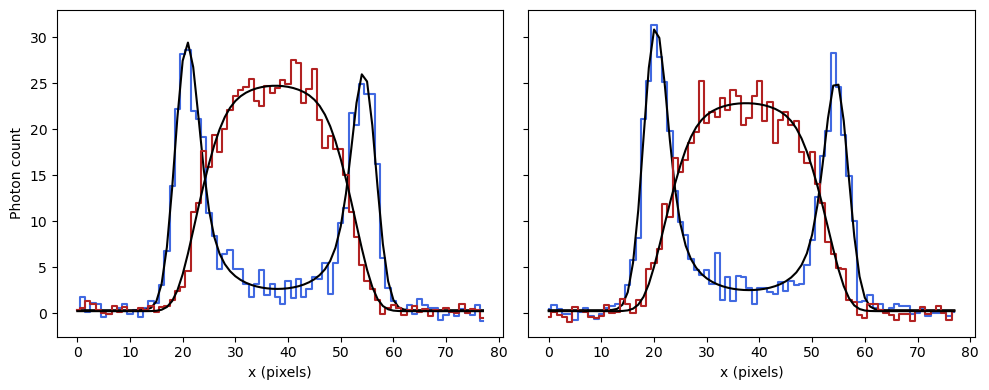

In [7]:
[[w1_A, p1_A], [w2_A, p2_A]] = L_multi(x, *opt_res_A.x)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0]/GAIN, where='mid', c='royalblue')
ax1.plot(x, w1_A, c='k')

ax1.step(x, kymo_plasma[0]/GAIN, where='mid', c='firebrick')
ax1.plot(x, p1_A, c='k')

# Second time point
ax2.step(x, kymo_wall[1]/GAIN, where='mid', c='royalblue')
ax2.plot(x, w2_A, c='k')

ax2.step(x, kymo_plasma[1]/GAIN, where='mid', c='firebrick')
ax2.plot(x, p2_A, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Photon count')

plt.tight_layout()

In [8]:
misc.fitted_params(opt_res_A, ['s_xy', 'l', 'dR', 's_gcx', 'b_plasma', 'b_tissue_wall', 'b_tissue_plasma', 'Iw1', 'Iw2', 'Ip1', 'Ip2', 'R_w1', 'R_w2', 'xc1', 'xc2', 'a1_1', 'a1_2'])

{'s_xy': (2.107195059514173, 0.040567038469156165),
 'l': (8.06306396027178, 1.0074695453111027),
 'dR': (6.120842313239709, 0.6136577730664439),
 's_gcx': (6.947039685442453, 1.1925176794224261),
 'b_plasma': (-0.3289710454800979, 0.74126012655528),
 'b_tissue_wall': (0.33552944529989076, 0.05294539468820524),
 'b_tissue_plasma': (0.2328187054832929, 0.047559319922845726),
 'Iw1': (201.88358008297683, 11.40983378480888),
 'Iw2': (203.46081361781293, 11.687586656305092),
 'Ip1': (29.204653043979633, 1.1825320431455444),
 'Ip2': (26.72953348447345, 1.0776122280248728),
 'R_w1': (17.559080485247296, 0.07254758031333201),
 'R_w2': (17.948490334909092, 0.07122944604248016),
 'xc1': (37.61732234000365, 0.034069458141877756),
 'xc2': (37.42960671184145, 0.03467982890588129),
 'a1_1': (-0.06067328171750803, 0.011988258425491982),
 'a1_2': (-0.10730080261462294, 0.012001278106700803)}

***

## Protocol B: The Ultimate Fit (only plasma fluorescence)

In [9]:
kymo_plasma = np.load('plasma.npy')

nt, nx = kymo_plasma.shape
x = np.arange(nx)

kymo_plasma = kymo_plasma.reshape((2, nt//2, nx)).mean(axis=1)

N_AVER = nt//2

## Enter PMT parameters (known from the calibration)

In [10]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Make an initial parameter guess

In [11]:
xc, s_xy, l, R_lum, I, b = track_vessel.ols_plasma(kymo_plasma[0]/GAIN, sigma_blur=1.5)

p0_B = [s_xy, l, b, *(2*[I]), *(2*[R_lum]), *(2*[xc])]

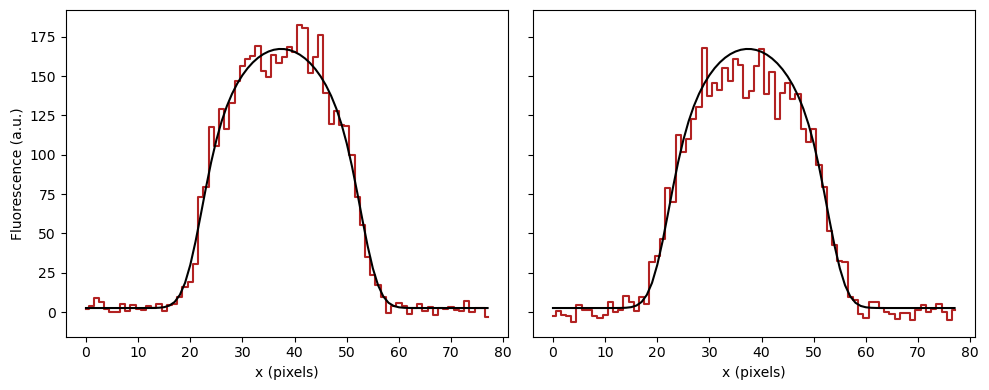

In [12]:
p1_B0, p2_B0 = L_multi_plasma(x, *p0_B)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_plasma[0], where='mid', c='firebrick')
ax1.plot(x, p1_B0*GAIN, c='k')

# Second time point
ax2.step(x, kymo_plasma[1], where='mid', c='firebrick')
ax2.plot(x, p2_B0*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

## Fit

In [13]:
opt_res_B = track_vessel.mle(x,
                             kymo_plasma,
                             L_multi_plasma,
                             p0_B,
                             N_AVER, 
                             ALPHA, 
                             SIGMA, 
                             minimize_options=dict(gtol=1e-3))
opt_res_B

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 525.9650115859863
        x: [-2.438e+00  3.011e+01  2.375e-01  6.034e+01  5.260e+01
             1.641e+01  1.725e+01  3.740e+01  3.732e+01]
      nit: 44
      jac: [-3.815e-05  3.052e-05  9.155e-05 -6.866e-05  6.104e-05
            -9.918e-05  2.594e-04  0.000e+00  2.289e-05]
 hess_inv: [[ 2.967e-02  2.240e+00 ...  6.882e-04 -2.772e-05]
            [ 2.240e+00  3.018e+02 ...  7.053e-02 -2.226e-02]
            ...
            [ 6.882e-04  7.053e-02 ...  5.971e-03 -2.179e-05]
            [-2.772e-05 -2.226e-02 ... -2.179e-05  6.260e-03]]
     nfev: 590
     njev: 59

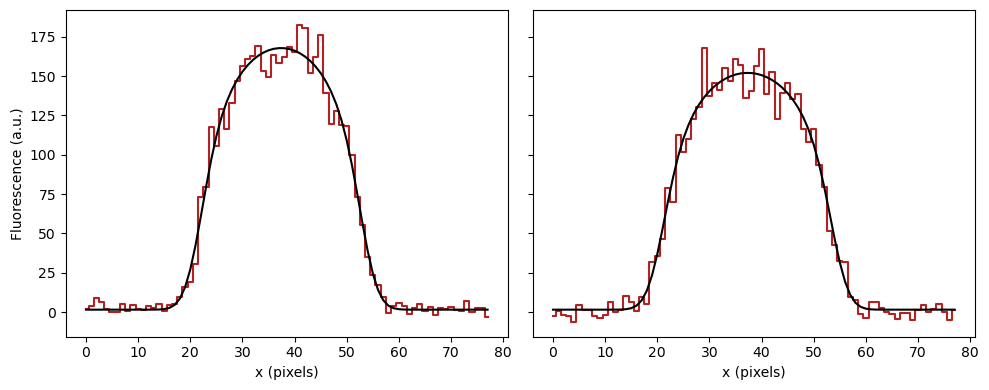

In [14]:
p1_B, p2_B = L_multi_plasma(x, *opt_res_B.x)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_plasma[0], where='mid', c='firebrick')
ax1.plot(x, p1_B*GAIN, c='k')

# Second time point
ax2.step(x, kymo_plasma[1], where='mid', c='firebrick')
ax2.plot(x, p2_B*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

In [15]:
misc.fitted_params(opt_res_B, ['s_xy', 'l', 'b', 'I1', 'I2', 'R1', 'R2', 'xc1', 'xc2'])

{'s_xy': (-2.438273861791581, 0.17225632870446325),
 'l': (30.105880795578592, 17.373159261385275),
 'b': (0.23745583772883383, 0.050463688760697185),
 'I1': (60.34058369006852, 25.94525969404946),
 'I2': (52.59910221301526, 22.150920198420124),
 'R1': (16.408071976282155, 0.24457637942672664),
 'R2': (17.247646049574, 0.2644389546532151),
 'xc1': (37.39772340944595, 0.07727468069475724),
 'xc2': (37.316627492670165, 0.079119615188768)}

***

## Protocol C: The Ultimate Fit (only wall fluorescence)

In [16]:
kymo_wall = np.load('wall.npy')

nt, nx = kymo_wall.shape
x = np.arange(nx)

kymo_wall = kymo_wall.reshape((2, nt//2, nx)).mean(axis=1)

N_AVER = nt//2

## Enter PMT parameters (known from the calibration)

In [17]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Make an initial parameter guess

In [18]:
xc, s_xy, l, R_wall, a1, I, b_plasma, b_tissue = track_vessel.ols_wall(kymo_wall[0]/GAIN, sigma_blur=1.5)

p0_C = [s_xy, l, b_plasma, b_tissue, 
        *(2*[I]), *(2*[R_wall]), *(2*[xc]), *(2*[a1])]

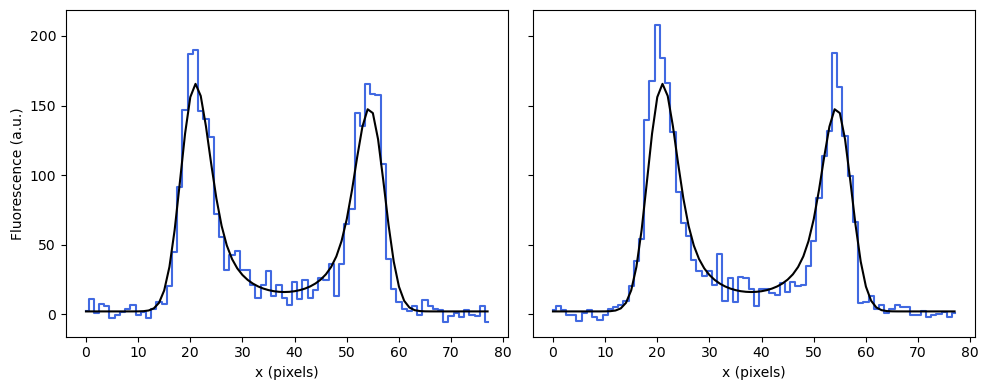

In [19]:
w1_C0, w2_C0 = L_multi_wall(x, *p0_C)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0], where='mid', c='royalblue')
ax1.plot(x, w1_C0*GAIN, c='k')

# Second time point
ax2.step(x, kymo_wall[1], where='mid', c='royalblue')
ax2.plot(x, w2_C0*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

## Fit

In [20]:
opt_res_C = track_vessel.mle(x,
                             kymo_wall,
                             L_multi_wall,
                             p0_C,
                             N_AVER, 
                             ALPHA, 
                             SIGMA, 
                             minimize_options=dict(gtol=1e-3))
opt_res_C

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 607.7487019427551
        x: [ 2.114e+00  7.833e+00 -1.580e-01  3.334e-01  1.993e+02
             2.008e+02  1.758e+01  1.791e+01  3.767e+01  3.745e+01
            -6.182e-02 -1.078e-01]
      nit: 33
      jac: [-1.373e-04 -2.289e-05 -1.526e-05  3.052e-05 -7.629e-06
             0.000e+00  7.629e-05  3.052e-05  3.052e-05 -5.341e-05
             1.297e-04  8.621e-04]
 hess_inv: [[ 1.827e-03 -3.175e-02 ...  1.568e-05  2.018e-05]
            [-3.175e-02  1.044e+00 ... -3.724e-04  4.665e-05]
            ...
            [ 1.568e-05 -3.724e-04 ...  1.489e-04  2.573e-06]
            [ 2.018e-05  4.665e-05 ...  2.573e-06  1.567e-04]]
     nfev: 533
     njev: 41

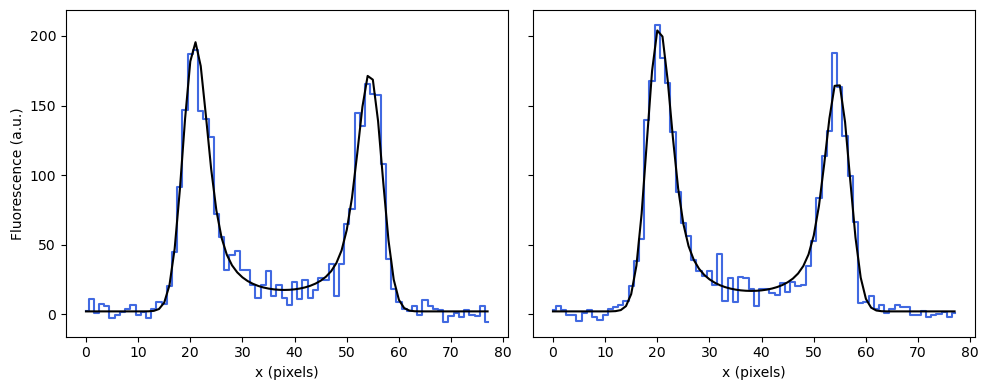

In [21]:
w1_C, w2_C = L_multi_wall(x, *opt_res_C.x)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0], where='mid', c='royalblue')
ax1.plot(x, w1_C*GAIN, c='k')

# Second time point
ax2.step(x, kymo_wall[1], where='mid', c='royalblue')
ax2.plot(x, w2_C*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

In [22]:
misc.fitted_params(opt_res_C, ['s_xy', 'l', 'b_plasma', 'b_tissue', 'Iw1', 'Iw2', 'R_w1', 'R_w2', 'xc1', 'xc2', 'a1_1', 'a1_2'])

{'s_xy': (2.114158137286465, 0.042746042712336486),
 'l': (7.832720427973505, 1.021544828101135),
 'b_plasma': (-0.15802667424428915, 0.7459556396848739),
 'b_tissue': (0.33343856532472754, 0.053206570015970546),
 'Iw1': (199.31816470633063, 11.382030628247032),
 'Iw2': (200.84748397183503, 11.498649028507785),
 'R_w1': (17.582938140330967, 0.07514440527583323),
 'R_w2': (17.909219698187055, 0.07398468306363327),
 'xc1': (37.67066298080901, 0.03891006512190463),
 'xc2': (37.45022610778766, 0.03885557324375462),
 'a1_1': (-0.06181862038637795, 0.012203764674089443),
 'a1_2': (-0.10781024324983249, 0.012519520521666211)}